# CLIP과의 상호작용

CLIP 모델을 다운로드 및 실행하고, 임의 이미지와 텍스트 입력 간의 유사성을 계산하고, 제로샷 이미지 분류를 수행하는 방법을 보여줍니다.

### Colab 에서 실행

ftfy는 "fixes text for you"의 약자로, 텍스트 데이터를 깔끔하게 정리해주는 Python 라이브러리

In [1]:
! pip install ftfy regex tqdm
# GitHub에서 openai의 CLIP 리포지토리를 직접 설치합니다.
! pip install git+https://github.com/openai/CLIP.git

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.1/53.1 kB 1.0 MB/s eta 0:00:00
  Cloning https://github.com/openai/CLIP.git to /tmp/pip-req-build-9utnj8cw
  Running command git clone --filter=blob:none --quiet https://github.com/openai/CLIP.git /tmp/pip-req-build-9utnj8cw
  Resolved https://github.com/openai/CLIP.git to commit a1d071733d7111c9c014f024669f959182114e33
  Preparing metadata (setup.py) ... done
  Created wheel for clip: filename=clip-1.0-py3-none-any.whl size=1369497 sha256=0275e4ceff6f3316381223dd110824219cfb3a8418a33c9e6bac2b24f6a52747
  Stored in directory: /tmp/pip-ephem-wheel-cache-mntmu3yn/wheels/da/2b/4c/d6691fa9597aac8bb85d2ac13b112deb897d5b50f5ad9a37e4
Successfully built clip


In [2]:
import numpy as np
import torch
from pkg_resources import packaging

print("Torch version:", torch.__version__)

Torch version: 2.0.1+cu118


# 모델 로딩

`clip.available_models()`는 사용 가능한 CLIP 모델의 이름을 나열합니다.

In [3]:
import clip

clip.available_models()

['RN50',
 'RN101',
 'RN50x4',
 'RN50x16',
 'RN50x64',
 'ViT-B/32',
 'ViT-B/16',
 'ViT-L/14',
 'ViT-L/14@336px']

In [4]:
# CLIP 모델 및 전처리 함수를 로드합니다. "ViT-B/32"는 CLIP의 모델 아키텍처를 지정합니다.
model, preprocess = clip.load("ViT-B/32")

# 모델을 GPU로 옮기고 평가 모드로 설정합니다.
model.cuda().eval()

# 모델의 입력 해상도, 문맥 길이, 어휘 크기 정보를 가져옵니다.
input_resolution = model.visual.input_resolution
context_length = model.context_length
vocab_size = model.vocab_size

# 모델의 파라미터 수, 입력 해상도, 문맥 길이, 어휘 크기를 출력합니다.
print("Model parameters:", f"{np.sum([int(np.prod(p.shape)) for p in model.parameters()]):,}")
print("Input resolution:", input_resolution)
print("Context length:", context_length)
print("Vocab size:", vocab_size)

100%|███████████████████████████████████████| 338M/338M [00:05<00:00, 68.7MiB/s]


Model parameters: 151,277,313
Input resolution: 224
Context length: 77
Vocab size: 49408


# 이미지 전처리

모델이 기대하는 이미지 해상도에 맞게 입력 이미지의 크기를 조정하고 가운데 부분을 자릅니다. 그 전에 데이터 세트 평균과 표준 편차를 사용하여 픽셀 강도를 정규화합니다.

`clip.load()`의 두 번째 반환 값에는 이 사전 처리를 수행하는 torchvision `Transform`이 포함되어 있습니다.



In [5]:
preprocess

Compose(
    Resize(size=224, interpolation=bicubic, max_size=None, antialias=warn)
    CenterCrop(size=(224, 224))
    <function _convert_image_to_rgb at 0x7ab3d6a684c0>
    ToTensor()
    Normalize(mean=(0.48145466, 0.4578275, 0.40821073), std=(0.26862954, 0.26130258, 0.27577711))
)

# 텍스트 전처리

`clip.tokenize()`를 사용하여 대소문자를 구분하지 않는 토크나이저를 사용합니다. 기본적으로 출력은 77개의 토큰 길이가 되도록 채워지며, 이는 CLIP 모델이 예상하는 것입니다.

In [6]:
clip.tokenize("Hello World!")

tensor([[49406,  3306,  1002,   256, 49407,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0]], dtype=torch.int32)

# 입력 이미지 및 텍스트 설정

8개의 예시 이미지와 해당 텍스트 설명을 모델에 제공하고 해당 feature 간의 유사성을 비교할 것입니다.

토크나이저는 대소문자를 구분하지 않으며 적절한 텍스트 설명을 자유롭게 제공할 수 있습니다.

In [7]:
import os
import skimage
import IPython.display
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np
from collections import OrderedDict
import torch

%matplotlib inline

# Jupyter Notebook 환경에서 시각화한 그래프나 이미지가 더욱 선명하게 출력되도록 하는 설정
%config InlineBackend.figure_format = 'retina'

# skimage 내의 이미지들을 prompt engineering 하여 저장
descriptions = {
    "page": "a page of text about segmentation",
    "chelsea": "a facial photo of a tabby cat",
    "astronaut": "a portrait of an astronaut with the American flag",
    "rocket": "a rocket standing on a launchpad",
    "motorcycle_right": "a red motorcycle standing in a garage",
    "camera": "a person looking at a camera on a tripod",
    "horse": "a black-and-white silhouette of a horse",
    "coffee": "a cup of coffee on a saucer"
}

In [10]:
skimage.data_dir

'/root/.cache/scikit-image/0.19.3/data'

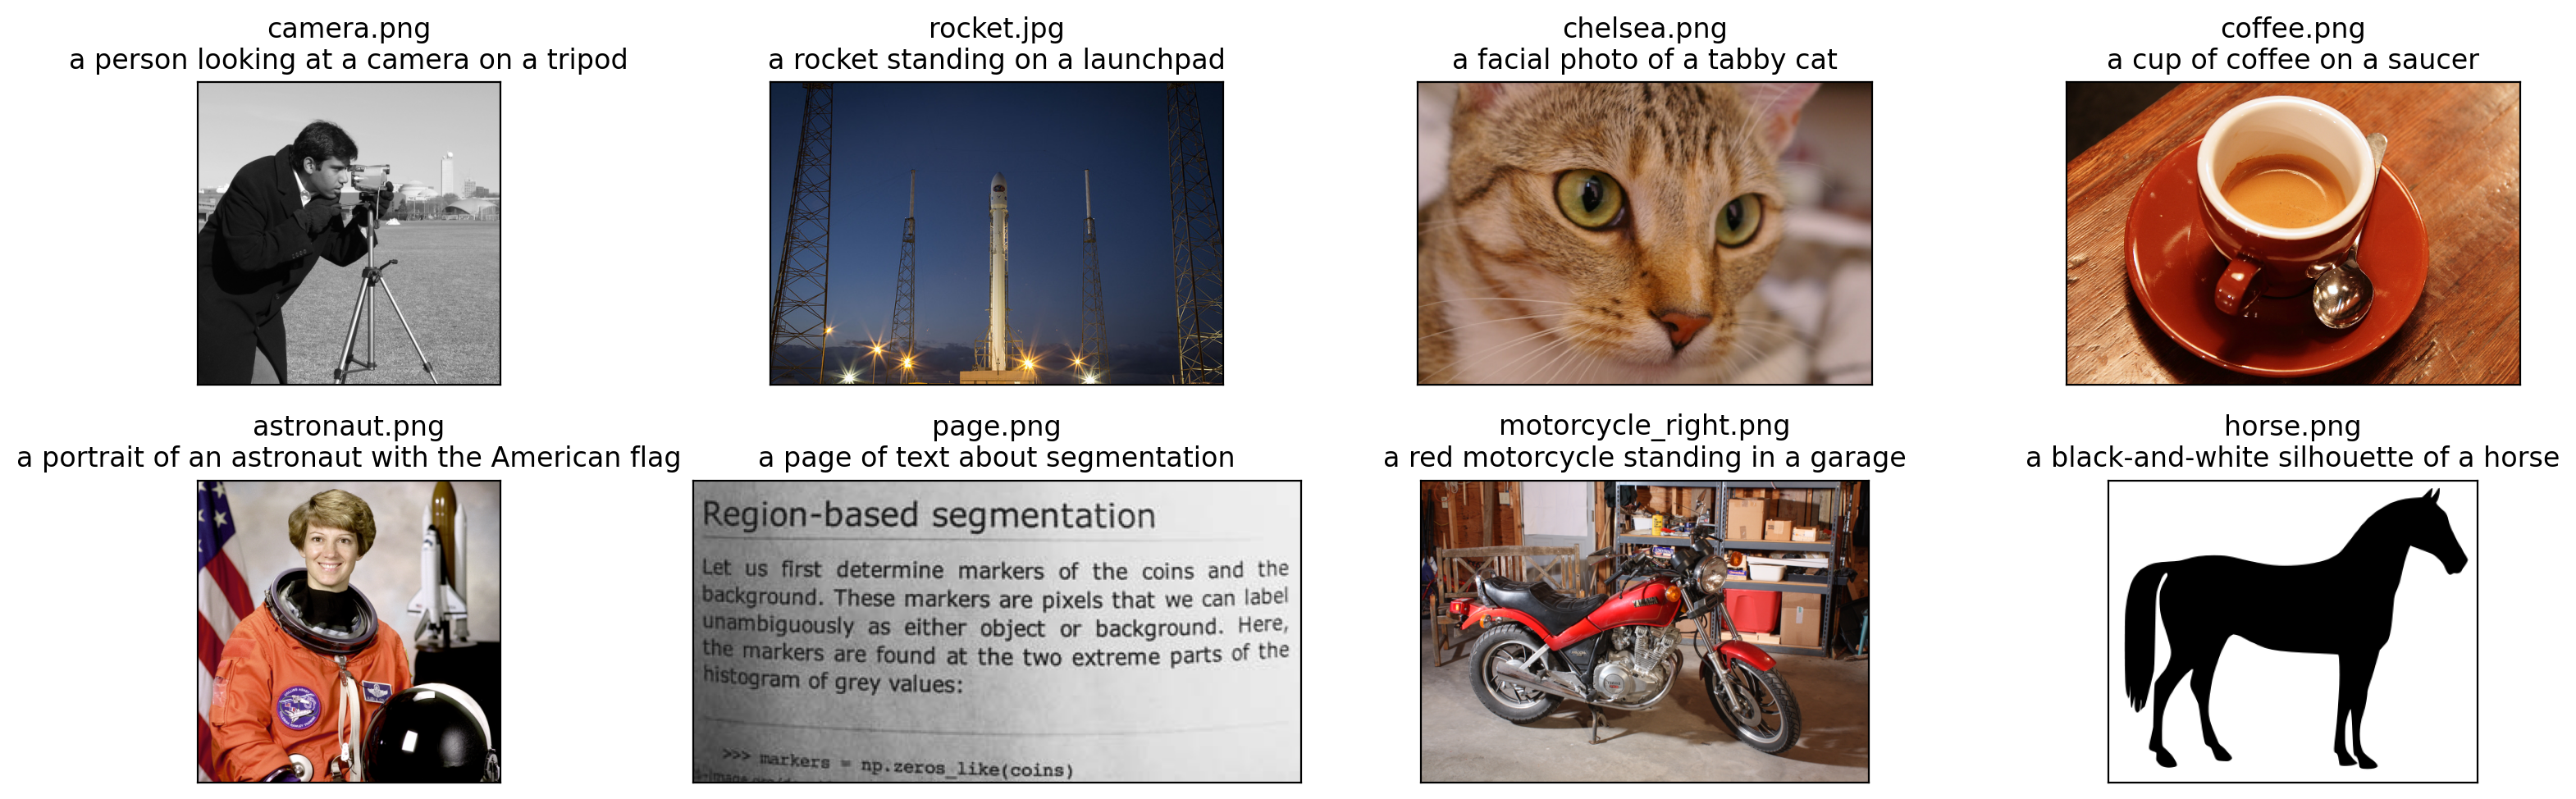

In [8]:
# 원본 이미지와 처리된 이미지, 그리고 텍스트를 저장하기 위한 리스트를 초기화합니다.
original_images = []
images = []
texts = []

plt.figure(figsize=(16, 5))

# skimage의 데이터 디렉토리에서 .png 또는 .jpg로 끝나는 모든 파일을 반복하여 처리합니다.
for filename in [filename for filename in os.listdir(skimage.data_dir) if filename.endswith(".png") or filename.endswith(".jpg")]:
    # 파일명에서 확장자를 제거하여 이미지의 이름을 얻습니다.
    name = os.path.splitext(filename)[0]

    # 설명이 없는 이미지는 무시합니다.
    if name not in descriptions:
        continue

    # 이미지를 열어 RGB 포맷으로 변환합니다.
    image = Image.open(os.path.join(skimage.data_dir, filename)).convert("RGB")

    # 현재 처리중인 이미지를 서브플롯으로 추가하고, 제목과 함께 그림을 그립니다.
    plt.subplot(2, 4, len(images) + 1)
    plt.imshow(image)
    plt.title(f"{filename}\n{descriptions[name]}")
    plt.xticks([])
    plt.yticks([])

    # 원본 이미지, 전처리된 이미지, 그리고 해당 이미지의 설명을 각각의 리스트에 추가합니다.
    original_images.append(image)
    images.append(preprocess(image))
    texts.append(descriptions[name])

plt.tight_layout()

## feature 생성

이미지를 정규화하고, 각 텍스트 입력을 토큰화하고, 모델의 순방향 전파를 실행하여 이미지와 텍스트 feature를 얻습니다.

In [12]:
# 이미지 리스트를 numpy 배열로 변환한 후, 이를 파이토치 텐서로 변환후 GPU로 전송
image_input = torch.tensor(np.stack(images)).cuda()

# 이미지에 대한 설명들 앞에 "This is "를 추가한 후, CLIP의 tokenize 함수를 사용하여 텍스트 토큰을 생성
text_tokens = clip.tokenize(["This is " + desc for desc in texts]).cuda()
text_tokens[0]

tensor([49406,   589,   533,   320,  2533,  1312,   536,   320,  3934,   525,
          320, 36141, 49407,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0], device='cuda:0',
       dtype=torch.int32)

In [13]:
# 그래디언트(미분 값)의 계산을 비활성화
with torch.no_grad():
    # 이미지 입력을 모델에 전달하여 이미지 특성을 추출
    image_features = model.encode_image(image_input).float()

    # 텍스트 토큰을 모델에 전달하여 텍스트 특성을 추출
    text_features = model.encode_text(text_tokens).float()

image_features.shape, text_features.shape

(torch.Size([8, 512]), torch.Size([8, 512]))

## 코사인 유사도 계산

feature를 정규화하고 각 쌍의 내적을 계산합니다.

In [15]:
# 이미지/text 특성의 L2 Norm(유클리드 노름)을 계산하여 특성 벡터를 정규화합니다.
image_features /= image_features.norm(dim=-1, keepdim=True)
text_features /= text_features.norm(dim=-1, keepdim=True)

# 텍스트 특성과 이미지 특성 사이의 유사성을 계산하기 위해 내적(dot product) 연산을 수행합니다.
# 결과적으로, 이 유사성 행렬의 각 요소는 특정 텍스트 설명과 이미지 간의 유사성 점수를 나타냅니다.
similarity = text_features.cpu().numpy() @ image_features.cpu().numpy().T

image_features.shape, text_features.shape, similarity.shape

(torch.Size([8, 512]), torch.Size([8, 512]), (8, 8))

Text(0.5, 1.0, 'Cosine similarity between text and image features')

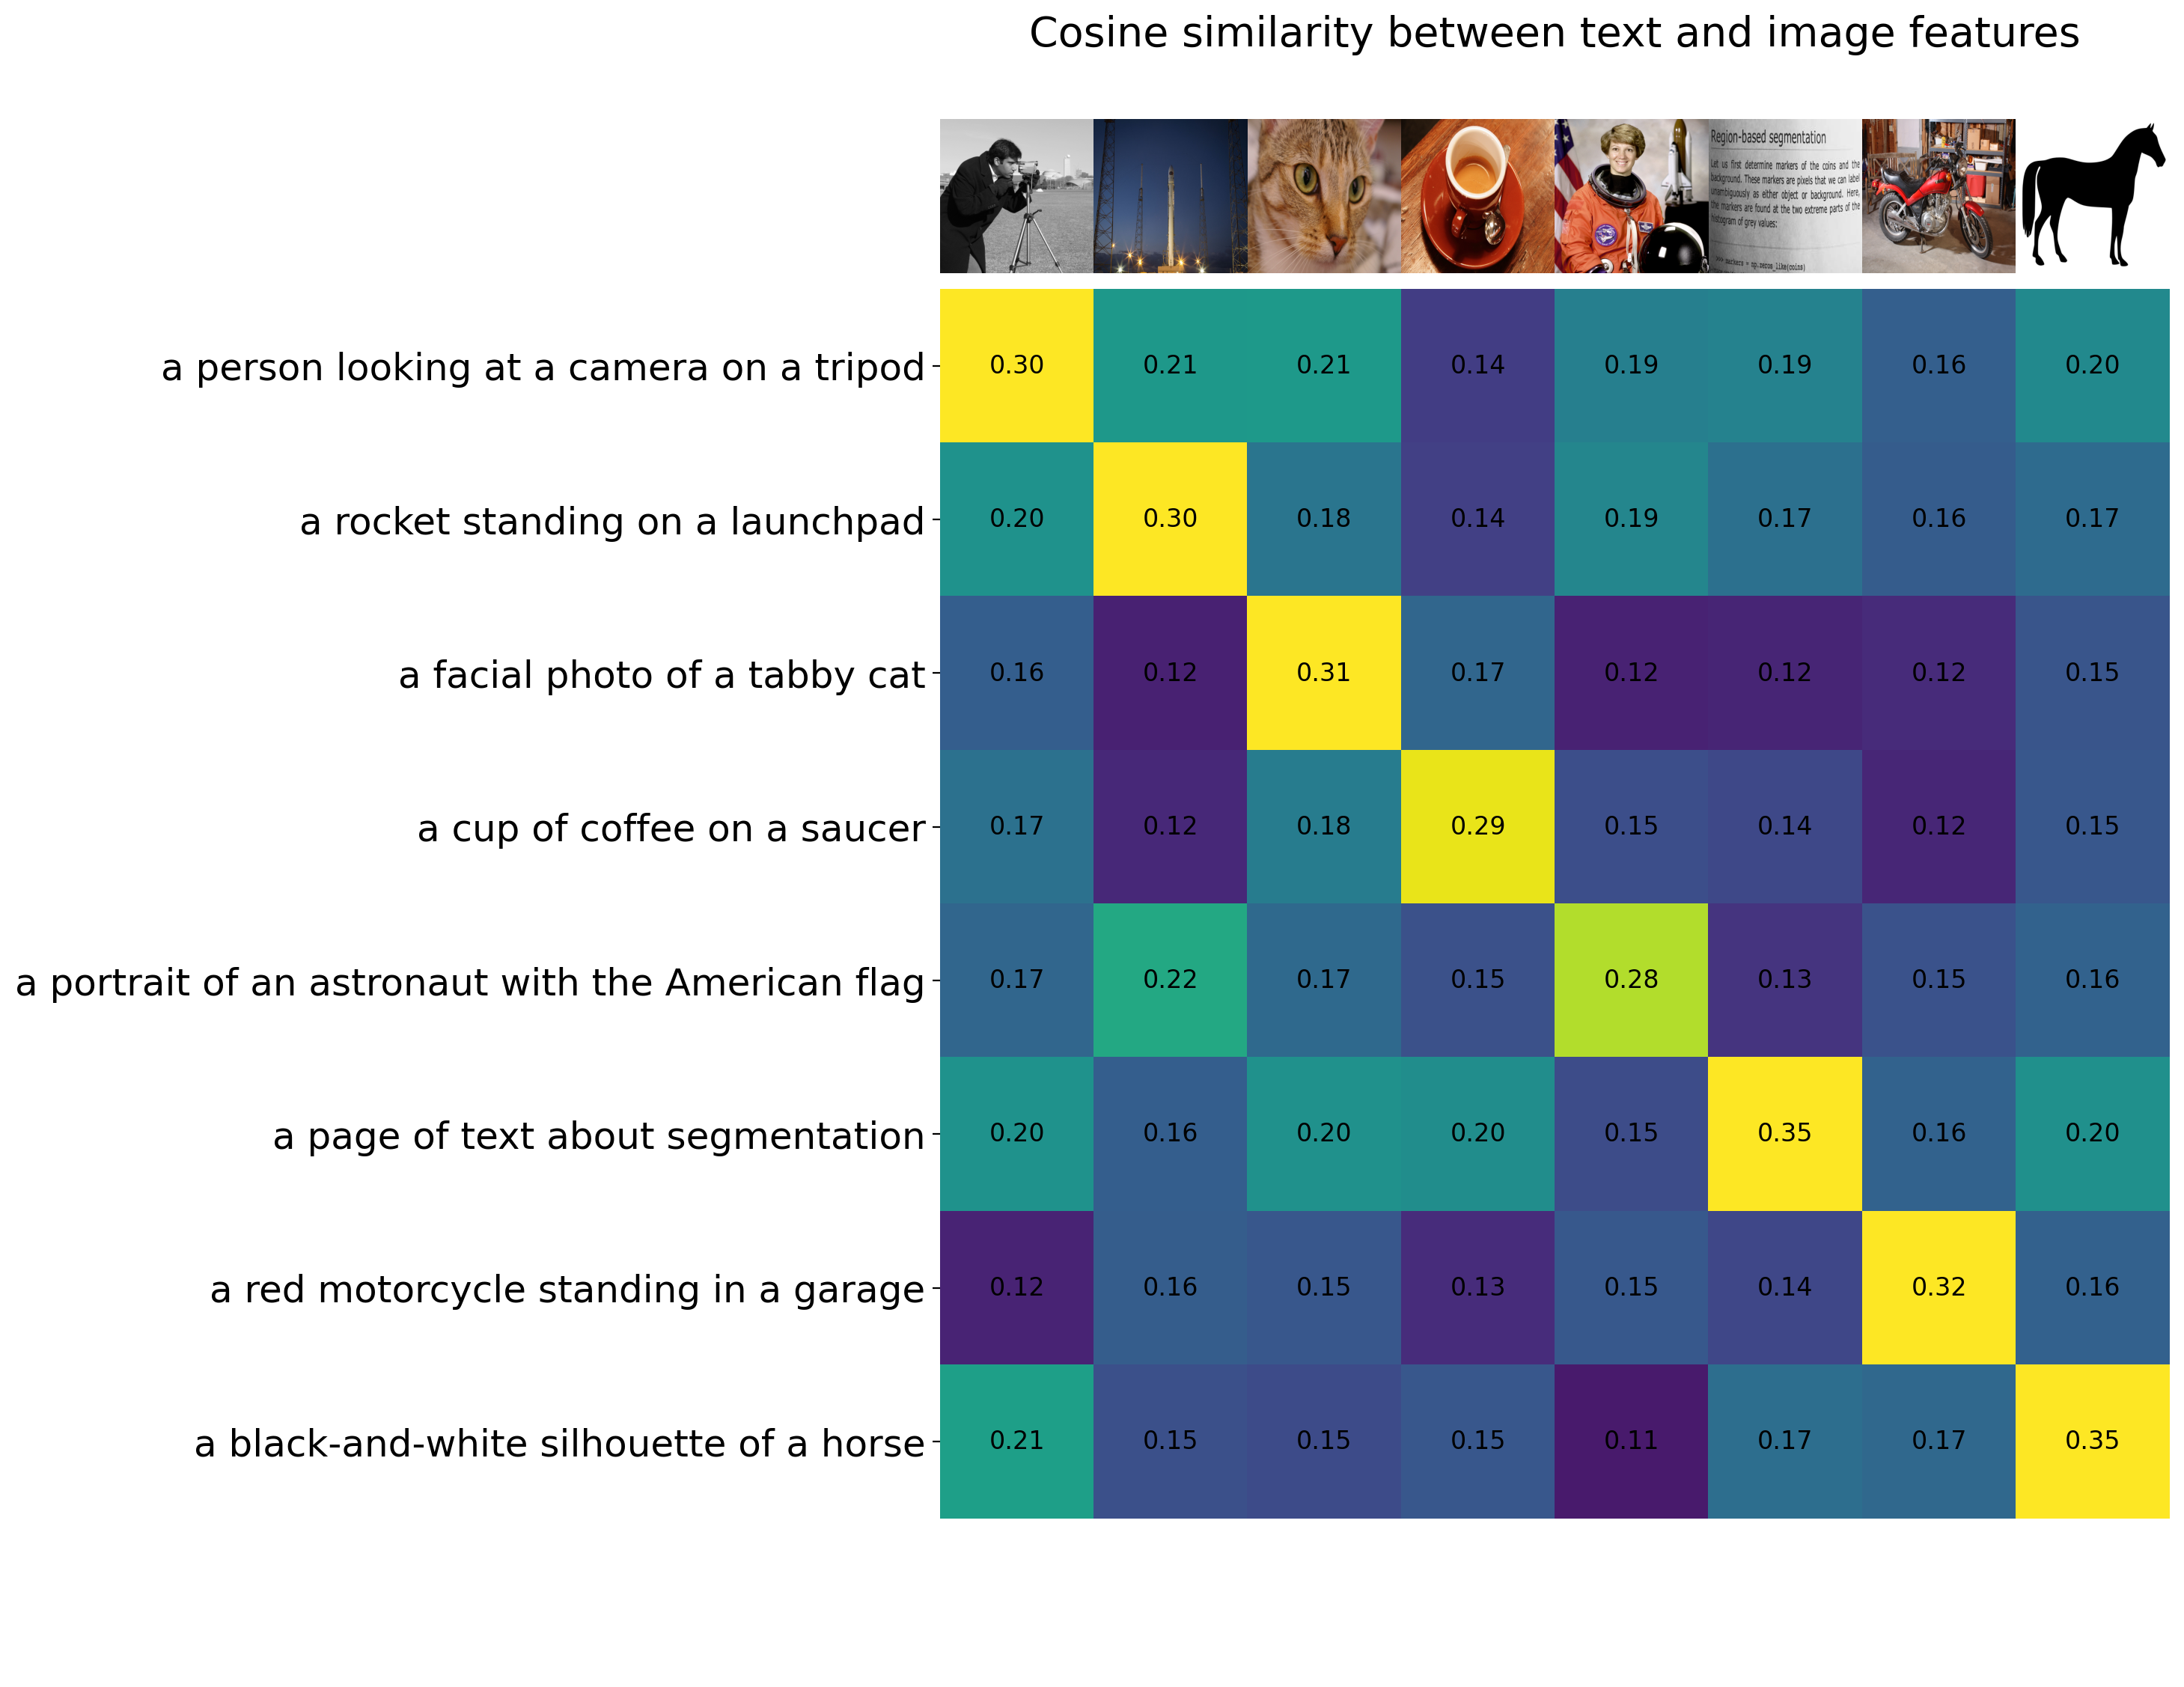

In [29]:
count = len(descriptions)

plt.figure(figsize=(20, 14))

# 이미지와 텍스트 사이의 코사인 유사도를 표시
plt.imshow(similarity, vmin=0.1, vmax=0.3)
plt.yticks(range(count), texts, fontsize=18)
plt.xticks([])

# 각 이미지가 위로 표시
for i, image in enumerate(original_images):
    plt.imshow(image, extent=(i - 0.5, i + 0.5, -1.6, -0.6), origin="lower")

# 유사도 매트릭스의 각 셀에 해당하는 값을 표시
for x in range(similarity.shape[1]):
    for y in range(similarity.shape[0]):
        plt.text(x, y, f"{similarity[y, x]:.2f}", ha="center", va="center", size=12)

# 그래프 주변의 테두리 제거
for side in ["left", "top", "right", "bottom"]:
  plt.gca().spines[side].set_visible(False)

# x축과 y축의 범위 설정
plt.xlim([-0.5, count - 0.5])
plt.ylim([count + 0.5, -2])

# 그래프 제목 설정
plt.title("Cosine similarity between text and image features", size=20)

# 제로샷 이미지 분류

코사인 유사성( x 100배)을 소프트맥스 연산의 로짓으로 사용하여 이미지를 분류할 수 있습니다.

In [30]:
from torchvision.datasets import CIFAR100

# CIFAR100 데이터셋을 다운로드하고 전처리 과정을 적용합니다.
# 데이터셋은 사용자의 홈 디렉토리에 있는 .cache 폴더에 저장됩니다.
cifar100 = CIFAR100(os.path.expanduser("~/.cache"), transform=preprocess, download=True)

100%|██████████| 169001437/169001437 [00:01<00:00, 103748262.41it/s]


Extracting /root/.cache/cifar-100-python.tar.gz to /root/.cache


In [35]:
print(cifar100.classes)

['apple', 'aquarium_fish', 'baby', 'bear', 'beaver', 'bed', 'bee', 'beetle', 'bicycle', 'bottle', 'bowl', 'boy', 'bridge', 'bus', 'butterfly', 'camel', 'can', 'castle', 'caterpillar', 'cattle', 'chair', 'chimpanzee', 'clock', 'cloud', 'cockroach', 'couch', 'crab', 'crocodile', 'cup', 'dinosaur', 'dolphin', 'elephant', 'flatfish', 'forest', 'fox', 'girl', 'hamster', 'house', 'kangaroo', 'keyboard', 'lamp', 'lawn_mower', 'leopard', 'lion', 'lizard', 'lobster', 'man', 'maple_tree', 'motorcycle', 'mountain', 'mouse', 'mushroom', 'oak_tree', 'orange', 'orchid', 'otter', 'palm_tree', 'pear', 'pickup_truck', 'pine_tree', 'plain', 'plate', 'poppy', 'porcupine', 'possum', 'rabbit', 'raccoon', 'ray', 'road', 'rocket', 'rose', 'sea', 'seal', 'shark', 'shrew', 'skunk', 'skyscraper', 'snail', 'snake', 'spider', 'squirrel', 'streetcar', 'sunflower', 'sweet_pepper', 'table', 'tank', 'telephone', 'television', 'tiger', 'tractor', 'train', 'trout', 'tulip', 'turtle', 'wardrobe', 'whale', 'willow_tree',

In [32]:
# CIFAR100 데이터셋의 각 클래스 이름(레이블) 앞에 "This is a photo of a"라는 문구를 추가하여 prompt engineering
text_descriptions = [f"This is a photo of a {label}" for label in cifar100.classes]
# 위에서 생성한 설명 텍스트 리스트를 CLIP 모델의 토큰화 함수를 사용하여 토큰화하고, 결과 텐서를 GPU로 이동
text_tokens = clip.tokenize(text_descriptions).cuda()
text_tokens[0]

tensor([49406,   589,   533,   320,  1125,   539,   320,  3055, 49407,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0], device='cuda:0',
       dtype=torch.int32)

In [33]:
with torch.no_grad():
    # 텍스트 토큰들을 CLIP 모델을 사용하여 특성 벡터로 인코딩
    text_features = model.encode_text(text_tokens).float()
    # 텍스트 특성 벡터를 L2 norm을 기준으로 정규화
    text_features /= text_features.norm(dim=-1, keepdim=True)

# 이미지 특성과 텍스트 특성 사이의 내적을 계산하여 유사도를 구하고, 이를 softmax를 통해 확률로 변환
text_probs = (100.0 * image_features @ text_features.T).softmax(dim=-1)
# 변환된 확률에서 상위 5개의 값과 해당 레이블의 인덱스를 추출
top_probs, top_labels = text_probs.cpu().topk(5, dim=-1)

top_probs.shape, top_labels.shape

(torch.Size([8, 5]), torch.Size([8, 5]))

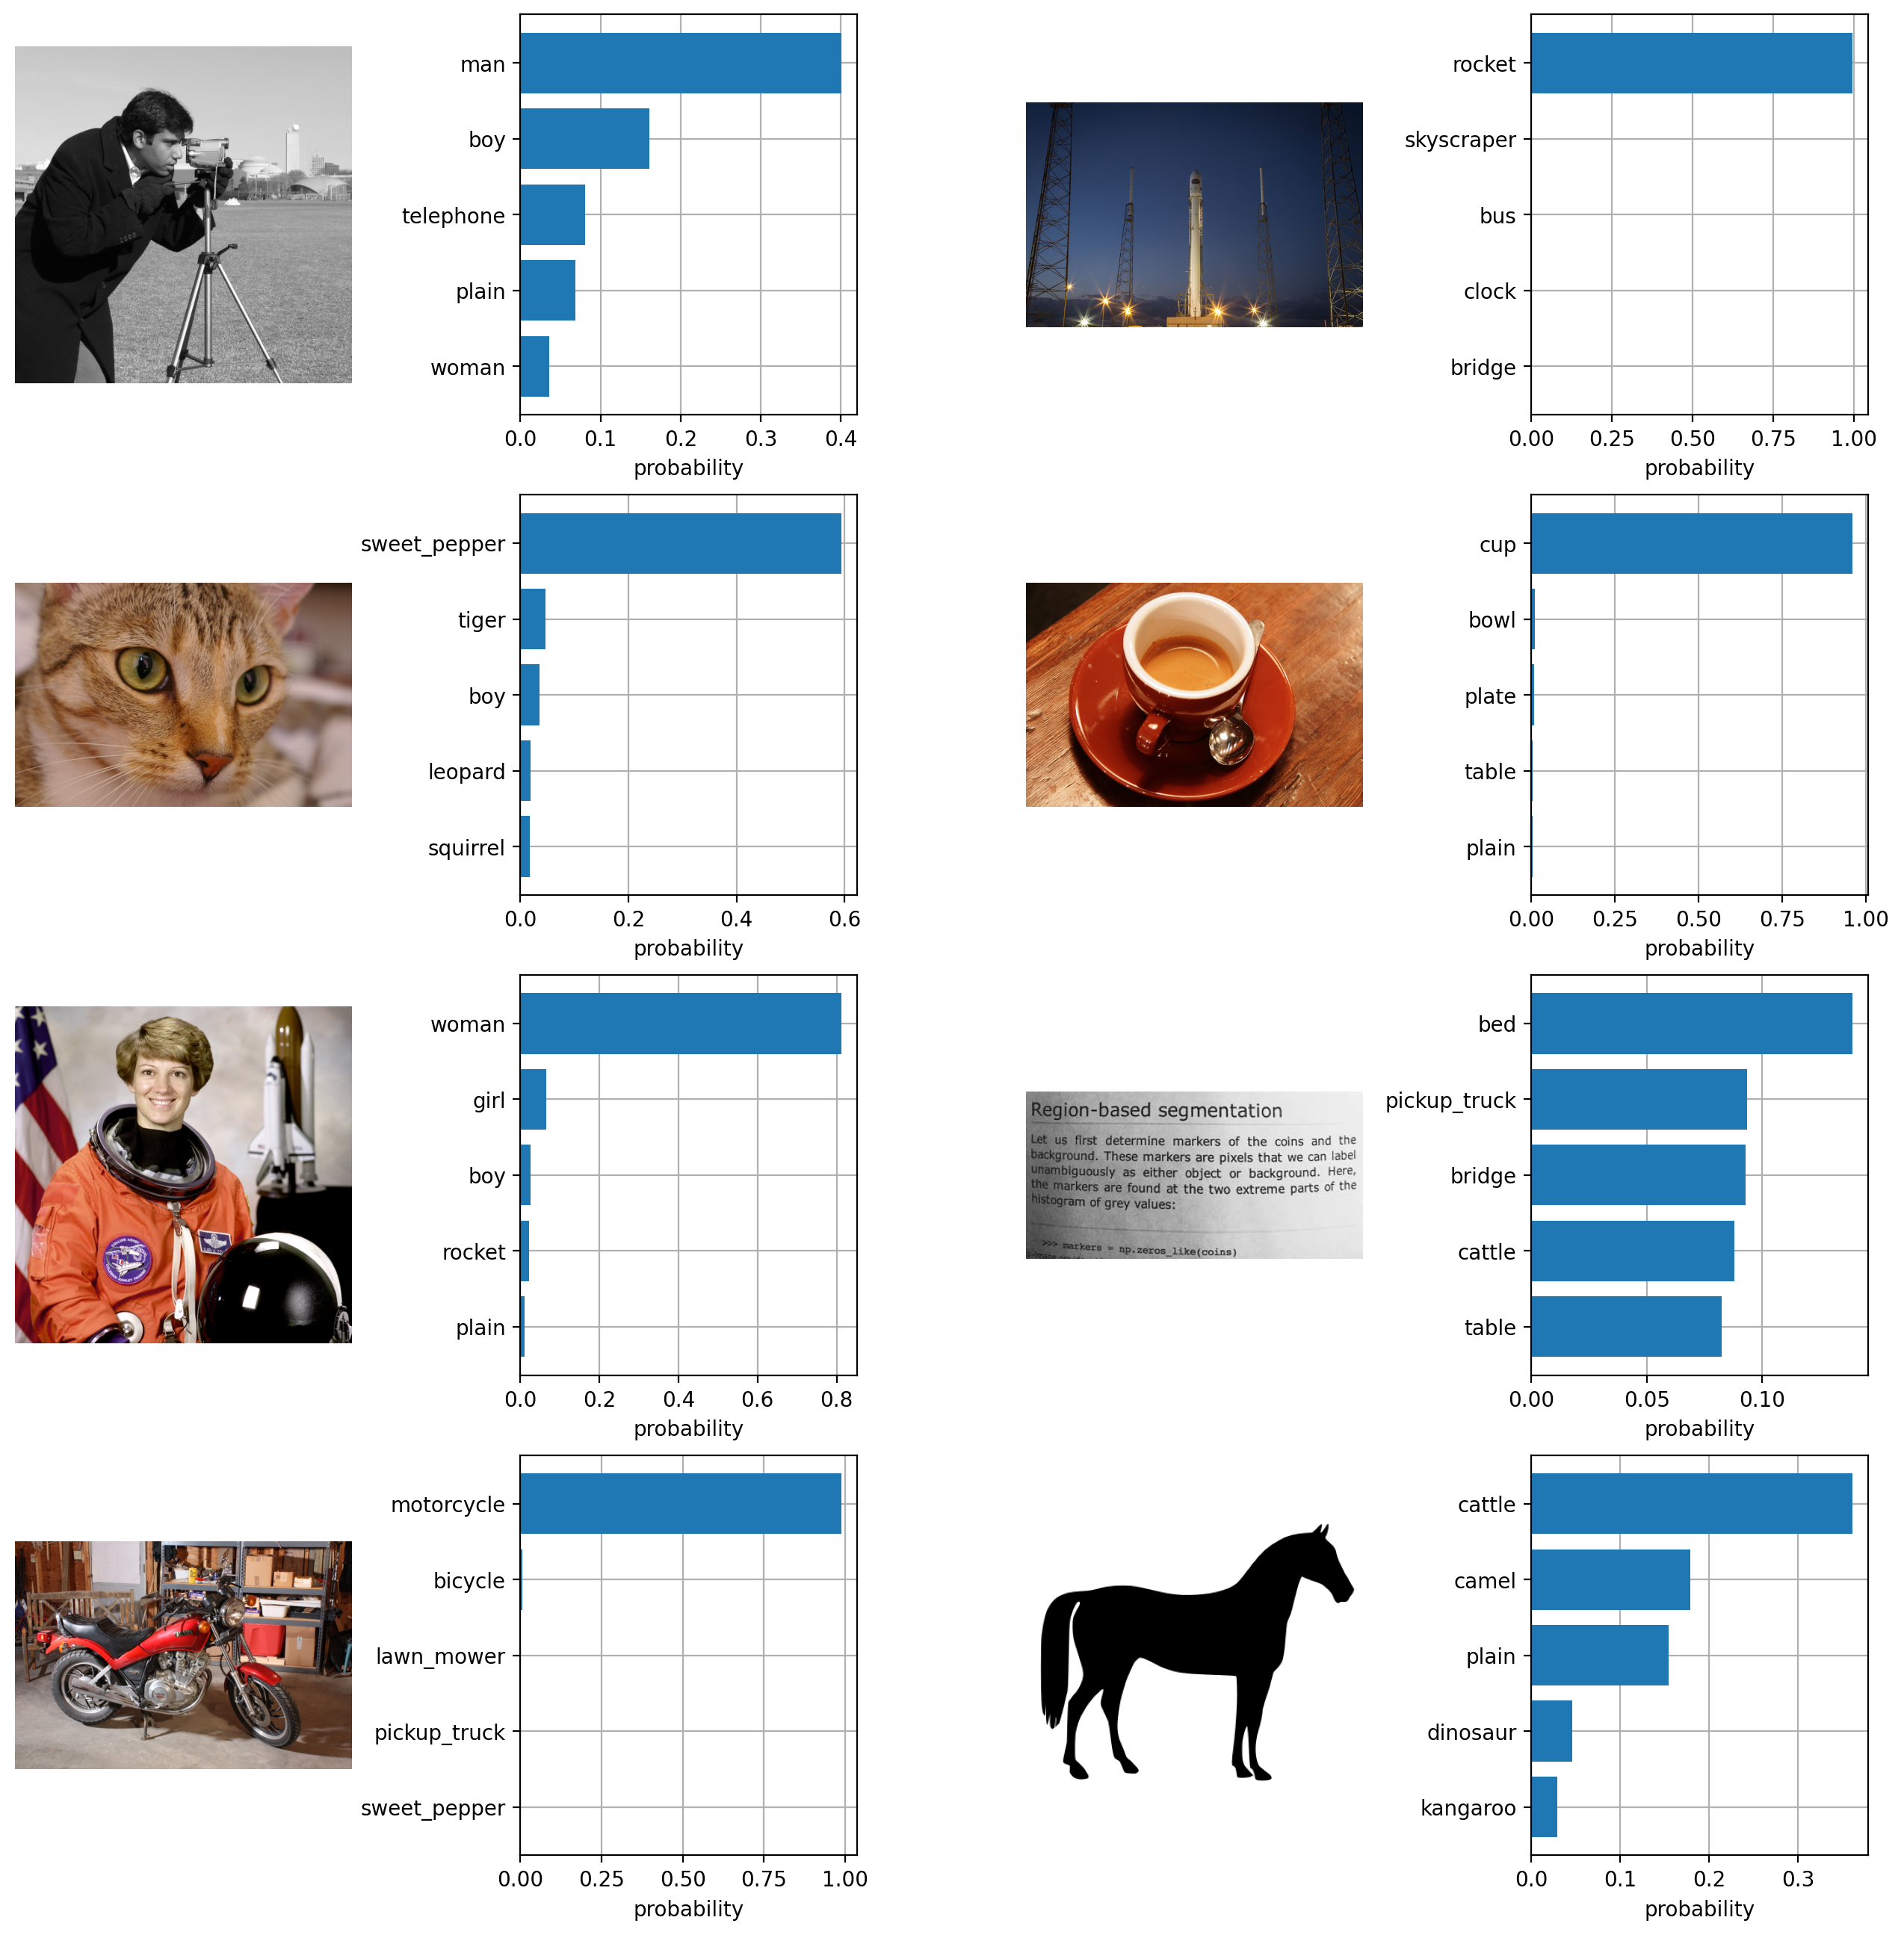

In [34]:
plt.figure(figsize=(16, 16))

for i, image in enumerate(original_images):
    plt.subplot(4, 4, 2 * i + 1)
    plt.imshow(image)
    plt.axis("off")

    # 상위 확률 값을 가진 레이블의 확률을 수평 바 차트로 출력
    plt.subplot(4, 4, 2 * i + 2)
    y = np.arange(top_probs.shape[-1])
    plt.grid()
    plt.barh(y, top_probs[i])  # 수평 바 차트 출력
    plt.gca().invert_yaxis()  # y축 역순으로 출력 (상위 확률 값이 상단에 위치하도록)
    plt.gca().set_axisbelow(True)  # 그리드 라인이 막대 뒤에 위치하도록 설정
    plt.yticks(y, [cifar100.classes[index] for index in top_labels[i].numpy()])  # y축 눈금 레이블 설정
    plt.xlabel("probability")

# 서브플롯 간 간격 조정
plt.subplots_adjust(wspace=0.5)
plt.show()